In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import YahooAnswers
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model, generate_sp_model

from tqdm import trange, tqdm

/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchte

In [2]:
learning_rate = 1e-4

nepochs = 10

batch_size = 32

max_len_q = 32

max_len_a = 64

root = "../../data/yahoo_answers_csv"

In [3]:
# YahooQA dataset class definition
class YahooQA(Dataset):
    def __init__(self, test_train="train"):
        # Read the Yahoo Answers dataset CSV file based on the test_train parameter (train or test)
        self.df = pd.read_csv(os.path.join(root, test_train + ".csv"),
                              names=["Class", "Q_Title", "Q_Content", "A"])
        
        # Fill missing values with empty string
        self.df.fillna('', inplace=True)
        
        # Combine Q_Title and Q_Content columns into a single Q column (question)
        self.df['Q'] = self.df['Q_Title'] + ' ' + self.df['Q_Content']
        
        # Drop Q_Title and Q_Content columns as they are no longer needed
        self.df.drop(['Q_Title', 'Q_Content'], axis=1, inplace=True)
        
        # Replace special characters with whitespace in the Q and A columns
        self.df['Q'] = self.df['Q'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['A'] = self.df['A'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

    # Method to get a single item (question, answer pair) from the dataset
    def __getitem__(self, index):
        # Get the question and answer texts at the given index, converted to lowercase
        question_text = self.df.loc[index]["Q"].lower()
        answer_text = self.df.loc[index]["A"].lower()

        return question_text, answer_text

    # Method to get the length of the dataset
    def __len__(self):
        # Return the total number of question-answer pairs in the dataset
        return len(self.df)

In [4]:
dataset_train = YahooQA(test_train="train")
dataset_test = YahooQA(test_train="test")
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
# Example of using the tokenizer
# Load the SentencePiece model
sp_model = load_sp_model("spm_user_ya.model")

# Create a tokenizer using the loaded model
tokenizer = sentencepiece_tokenizer(sp_model)

# Iterate over tokens generated by the tokenizer
for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creating']


In [6]:
# Define a function to yield tokens from a file
def yield_tokens(file_path):
    # Open the file in UTF-8 encoding
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate over each line in the file
        for line in f:
            # Yield the token split by tab character
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
# Define special tokens with special_first=True to place them at the beginning of the vocabulary

vocab = build_vocab_from_iterator(
    yield_tokens("spm_ag_news.vocab"),
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

# Set default index for out-of-vocabulary tokens
vocab.set_default_index(vocab['<unk>'])

In [7]:
# Data transform to turn text into vocab tokens
q_transform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_user_ya.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len_q),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

# Define transformation pipeline for answers
a_transform = T.Sequential(
    
    # Tokenize sentences using pre-existing SentencePiece tokenizer model
    T.SentencePieceTokenizer("spm_user_ya.model"),
    
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    
    # Add <sos> token at the beginning of each sentence (index 3 in vocabulary)
    T.AddToken(3, begin=True),
    
    # Crop the sentence if it is longer than the max answer length
    T.Truncate(max_seq_len=max_len_a),
    
    # Add <eos> token at the end of each sentence (index 4 in vocabulary)
    T.AddToken(4, begin=False),
    
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)

In [8]:
# Define LSTM model class
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers=1, emb_size=128, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_emb, emb_size)

        # MLP layer for embedding
        self.mlp_emb = nn.Sequential(
            nn.Linear(emb_size, emb_size),
            nn.LayerNorm(emb_size),
            nn.ELU(),
            nn.Linear(emb_size, emb_size)
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.25
        )

        # MLP layer for output
        self.mlp_out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size // 2, num_emb)
        )
        
    def forward(self, input_seq, hidden_in, mem_in):
        # Embed input sequence
        input_embs = self.embedding(input_seq) # (bs, t, emb_size)
        # Pass through MLP for embedding
        input_embs = self.mlp_emb(input_embs) # (bs, t, emb_size)
                
        # Pass through LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in)) # (bs, t, hidden_size)
                
        # Pass through MLP for output
        return self.mlp_out(output), hidden_out, mem_out
        # (bs, t, vocab_size)

In [9]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

emb_size = 128
hidden_size = 512
num_layers = 4

lstm_qa = LSTM(num_emb=len(vocab), num_layers=num_layers, emb_size=emb_size, hidden_size=hidden_size).to(device)

optimizer = optim.Adam(lstm_qa.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

training_loss_logger = []

In [10]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lstm_qa.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 15484835 (Approximately 15 Million) Parameters!


In [11]:
import sys

In [12]:
for q_text, a_text in data_loader_train:
    print(q_text[8])
    print(a_text[8])
    break

how do u know when to start trusting somebody and if its really worth it? 
trust is something that has to be earned but once that trust is built it is defiantly worth while...life can be so hard without trust in relationships and life it's self what have you got to hold onto


In [33]:
# Training loop
for epoch in range(nepochs):    
    
    # Set LSTM model to training mode
    lstm_qa.train()
    
    steps = 0
    
    # Iterate over batches in training data loader
    for q_text, a_text in data_loader_train:
        
        # Transform both question and answer text
        q_text_tokens = q_transform(list(q_text)).to(device) # (bs, t)
        a_text_tokens = a_transform(list(a_text)).to(device) # (bs, t)
        
        # Inputs and outputs for the answer next-token prediction
        a_input_text = a_text_tokens[:, :-1] # (bs, t)
        a_output_text = a_text_tokens[:, 1:] # (bs, t)
        
        # Batch size
        bs = q_text_tokens.shape[0]
        
        # Initialise the memory buffers
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Encode the whole question sequence
        _, hidden, memory = lstm_qa(q_text_tokens, hidden, memory)

        # NEW!!! We run the model through on the question input. Then we run the hidden and cell state to the next pass, with the answer text
        # Perform a "next-token" prediction on the answer sequence
        # providing the model with the memory buffers from the question-encoding step
        pred, hidden, memory = lstm_qa(a_input_text, hidden, memory)

        # Calculate loss
        loss = loss_fn(pred.transpose(1, 2), a_output_text) # (bs, vocab_size, T) -> (bs, T)

        # Zero gradients, perform backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log training loss
        training_loss_logger.append(loss.item())
        print(loss)

tensor(6.6963, grad_fn=<NllLoss2DBackward0>)
tensor(6.7203, grad_fn=<NllLoss2DBackward0>)
tensor(6.7486, grad_fn=<NllLoss2DBackward0>)
tensor(6.6988, grad_fn=<NllLoss2DBackward0>)
tensor(6.2606, grad_fn=<NllLoss2DBackward0>)
tensor(6.2986, grad_fn=<NllLoss2DBackward0>)
tensor(6.9774, grad_fn=<NllLoss2DBackward0>)
tensor(6.4790, grad_fn=<NllLoss2DBackward0>)
tensor(6.4927, grad_fn=<NllLoss2DBackward0>)
tensor(6.1563, grad_fn=<NllLoss2DBackward0>)
tensor(5.7974, grad_fn=<NllLoss2DBackward0>)
tensor(6.1200, grad_fn=<NllLoss2DBackward0>)
tensor(6.6003, grad_fn=<NllLoss2DBackward0>)
tensor(6.3935, grad_fn=<NllLoss2DBackward0>)
tensor(6.8094, grad_fn=<NllLoss2DBackward0>)
tensor(6.0854, grad_fn=<NllLoss2DBackward0>)
tensor(5.6677, grad_fn=<NllLoss2DBackward0>)
tensor(5.6577, grad_fn=<NllLoss2DBackward0>)
tensor(5.7070, grad_fn=<NllLoss2DBackward0>)
tensor(5.6252, grad_fn=<NllLoss2DBackward0>)
tensor(5.0750, grad_fn=<NllLoss2DBackward0>)
tensor(5.7138, grad_fn=<NllLoss2DBackward0>)
tensor(5.8

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcceff0c10>
Traceback (most recent call last):
  File "/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/kennykguo/anaconda3/envs/deep-learn

KeyboardInterrupt: 

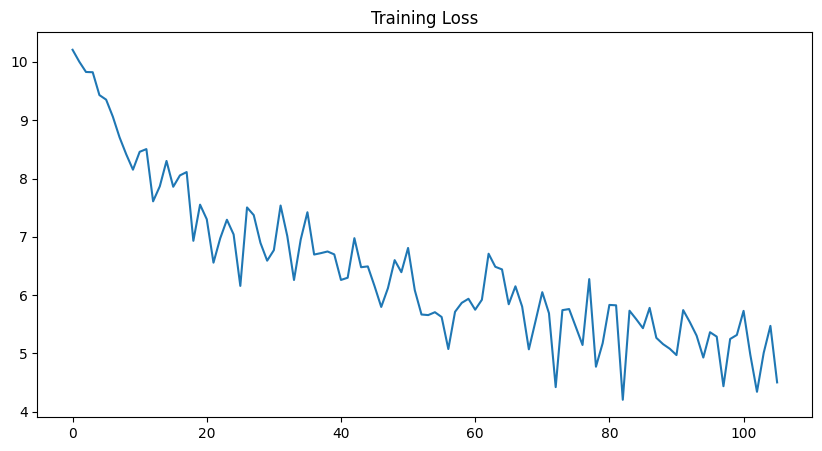

In [34]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [35]:
# Get a question and its corresponding answer from the test dataset
q_text, a_text = next(iter(data_loader_test))

In [36]:
# Choose an index from the test data loader
index = 0

# Display the selected question
print("QUESTION:")
print(q_text[index])

# Initialize the prompt with the selected question
init_prompt = [q_text[index]]

# Transform the initial prompt into tokens and move to device
input_tokens = q_transform(init_prompt).to(device)

# Add Start-Of-Answer token to prompt the network to start generating the answer
input_tokens = torch.cat((input_tokens, 3 * torch.ones(1, 1, device=device).long()), 1)

print("\nINITIAL PROMPT TOKENS:")
print(input_tokens)
print("VOCABULARY TOKENS:")
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

# Temperature parameter for sampling
temp = 0.8

QUESTION:
does anyone know how to get cheap or free dental work done? help! i need extensive dental work. due to limited funds and no insurance for so long. i'm ashamed to be seen in public and have lost my confidence and personality. sometimes i feel like i can't go on.

INITIAL PROMPT TOKENS:
tensor([[    1,  8530,  5140, 12040, 11000, 18552, 10203,  6831, 14134,  9937,
             3, 19792,  8566,     3, 10765,     3, 11085, 13683,  9361,     3,
         19792,    50,  8694, 18552, 12414, 10026,  5059, 13828, 11416,  9825,
         17325, 12534,     2,     3]])
VOCABULARY TOKENS:
['<sos>', '▁does', '▁anyone', '▁know', '▁how', '▁to', '▁get', '▁cheap', '▁or', '▁free', '<unk>', '▁work', '▁done', '<unk>', '▁help', '<unk>', '▁i', '▁need', '▁extensive', '<unk>', '▁work', '.', '▁due', '▁to', '▁limited', '▁funds', '▁and', '▁no', '▁insurance', '▁for', '▁so', '▁long', '<eos>', '<unk>']


In [37]:
# Generate text tokens
log_tokens = []
# Set LSTM model to evaluation mode
lstm_qa.eval()

# Disable gradient calculation
with torch.no_grad():    
    # Initialize hidden and memory tensors
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)
    
    # Iterate over a maximum of 100 tokens
    for i in range(100):
        # Forward pass through LSTM model
        data_pred, hidden, memory = lstm_qa(input_tokens, hidden, memory)
        
        # Sample from the distribution of probabilities
        dist = Categorical(logits=data_pred[:, -1, :]/temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append sampled token to log_tokens list
        log_tokens.append(input_tokens.cpu())
        
        # Check if the sampled token is the End-Of-Answer token
        if input_tokens.item() == 4:
            break

In [38]:
# Convert the list of token indices into text using the vocabulary
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))

# Print the generated text
print(pred_text)

linked▁away▁what▁bellevue<unk><unk>▁all▁progress▁is▁require<unk><pad>▁gare<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>▁bernard<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>▁spy<pad><pad><pad>▁composer<pad><pad><pad><pad><pad><pad><pad>iff<pad><pad>▁just▁opec<pad><pad><pad><pad>▁laboratories<pad><pad><pad>.<pad><pad><pad><pad>


In [39]:
# Clean up the generated text by replacing special tokens and removing unwanted characters
cleaned_text = pred_text.replace("▁", " ").replace("<unk>", "").replace("<eoa>", "")

# Print the cleaned text
print(cleaned_text)

linked away what bellevue all progress is require<pad> gare<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> bernard<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> spy<pad><pad><pad> composer<pad><pad><pad><pad><pad><pad><pad>iff<pad><pad> just opec<pad><pad><pad><pad> laboratories<pad><pad><pad>.<pad><pad><pad><pad>


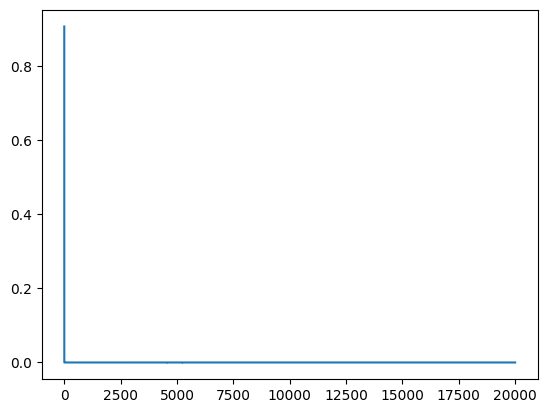

In [40]:
# Have a look at the next token probabilities 
plt.plot(F.softmax(data_pred[:, -1, :]/temp, -1).cpu().numpy().flatten())